# sparse coding notebook

In [240]:
import numpy as np
import theano 
import theano.tensor as T
import matplotlib.pyplot as plt
import math, os
from scipy.io import loadmat 
from sklearn.feature_extraction.image import PatchExtractor
from theano.compat.python2x import OrderedDict
from utils import tile_raster_images as tri
%matplotlib inline

In [241]:
data = loadmat("IMAGES.mat")

In [242]:
ims = np.transpose(data['IMAGES'], (2,0,1))

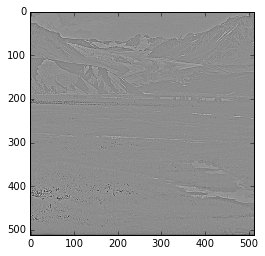

In [243]:
plt.imshow(ims[9], cmap = 'gray') 
plt.show()

In [244]:
shape = (8,8)
dim = np.prod(shape)
patches = PatchExtractor(shape, 64*64).transform(ims)
patches = patches.reshape(-1,dim).astype('float32')

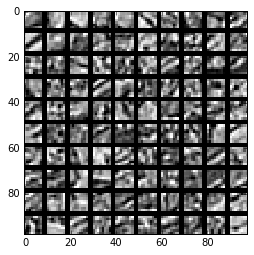

In [245]:
im = tri(patches[:100], shape, (10, 10), (2,2))
plt.imshow(im, cmap='gray', interpolation='nearest')

In [246]:
patches.shape

(40960, 64)

# starting theano

In [247]:
plot_folder = '/home/keniapina/plots/'
sparse_coding = True

if sparse_coding:
    sub = 'sc'
else:
    sub = 'mca'  

In [248]:
n_batch = 128
n_iter = 200
epochs = 50
n_neurons = 2*dim 

In [249]:
x = theano.shared(np.zeros((n_batch,dim)).astype('float32'))
w = np.random.randn(n_neurons,dim)
w_norm = np.sqrt(np.sum(w**2, axis=1, keepdims=True))
w = theano.shared((w/w_norm).astype('float32'))
a = theano.shared(np.zeros((n_batch,n_neurons)).astype('float32'))
x_batch = T.matrix() 

In [250]:
lam = .5 
eps_a = .1
eps_w = .1

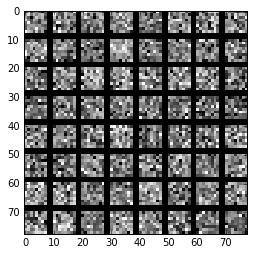

In [251]:
im = tri(w.get_value()[:64], shape, (8, 8), (2,2))
plt.imshow(im, cmap='gray', interpolation='nearest')
plt.savefig(os.path.join(plot_folder, sub, 'initial_image.png'))

In [252]:
if sparse_coding:
    x_hat = T.dot(a,w)
else:
    x_hat = 1.
recon = (.5*(x- x_hat)**2).sum(axis=1).mean()
coeff = abs(a).sum(axis=1).mean()
l0 = T.neq(a,0.).sum(axis=1).mean()
costfunction = recon+ lam*coeff 
snr = T.mean(x.norm(2,axis=1)**2/(x-x_hat).norm(2,axis=1)**2)
grad_a = T.grad(costfunction,a)  
grad_w = T.grad(costfunction,w)
grad_recon_a = T.grad(recon,a)
grad_sparse_a = T.grad(lam*coeff, a)

In [253]:
# first function will zero out the a's 
# step_a will begin gradiant descent on a
# step_w will begin gradient descent on w 
updates = OrderedDict()
updates[a] = 0.*a 
zero_a = theano.function([],[],updates = updates)

updates = OrderedDict()
a_prime = a - eps_a*grad_recon_a
a_dprime = a_prime - eps_a*grad_sparse_a
m = T.eq(T.sgn(a_prime), T.sgn(a_dprime))
updates[a] = m*a_dprime
step_a = theano.function([],[costfunction,recon,coeff,l0, snr],updates = updates)

updates = OrderedDict()
updates[x] = x_batch
update_x = theano.function([x_batch],[],updates = updates)

updates = OrderedDict()
wp = w - eps_w*grad_w
wp_norm = T.sqrt(T.sum(w**2, axis=1, keepdims=True))
updates[w] = wp/wp_norm
step_w = theano.function([],[costfunction],updates = updates) 

reconstruct = theano.function([],x_hat)

# Train the model

In [254]:
cost_array = np.zeros((epochs, n_iter))
recon_array = np.zeros((epochs, n_iter))
coeff_array = np.zeros((epochs,n_iter))
l0_array = np.zeros((epochs,n_iter))
snr_array = np.zeros((epochs, n_iter))
hist_array = np.zeros((epochs, n_batch, n_neurons))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


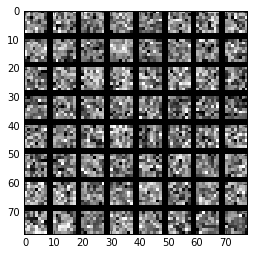

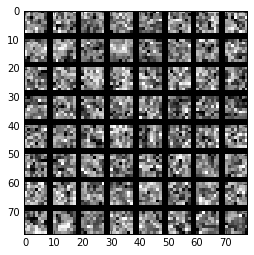

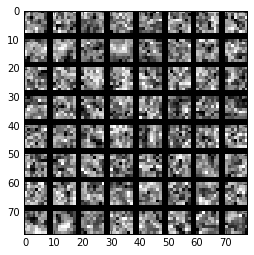

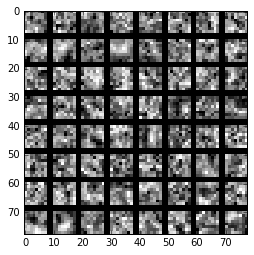

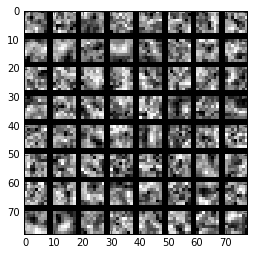

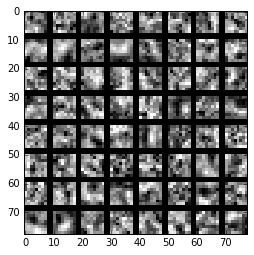

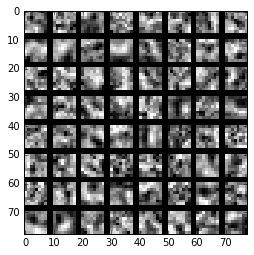

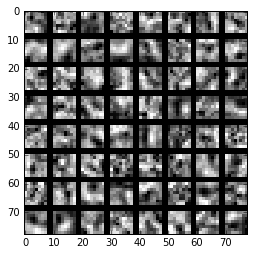

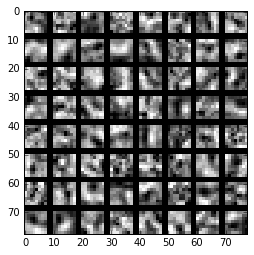

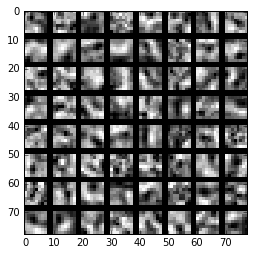

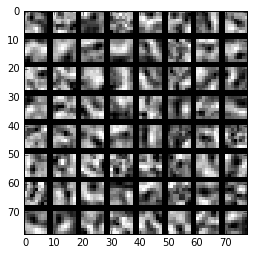

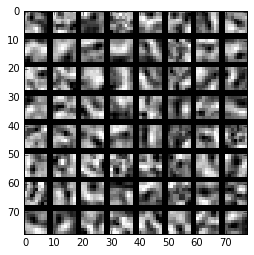

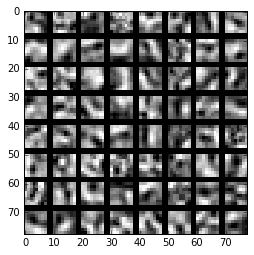

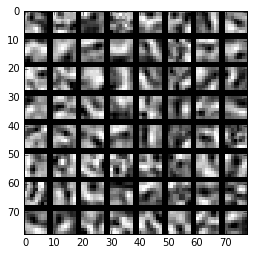

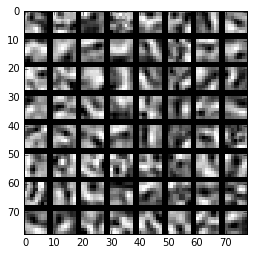

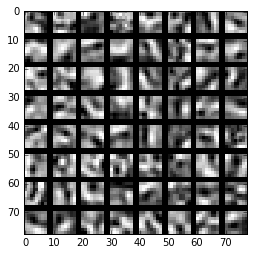

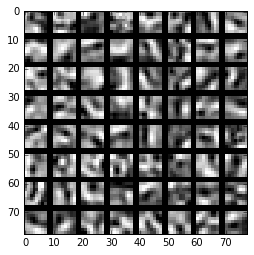

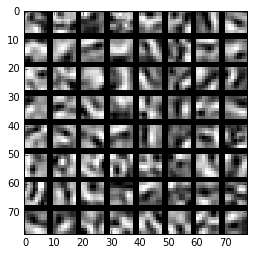

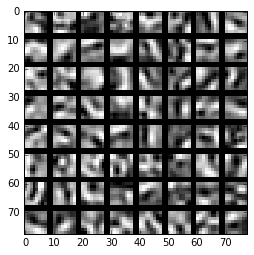

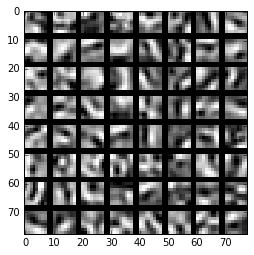

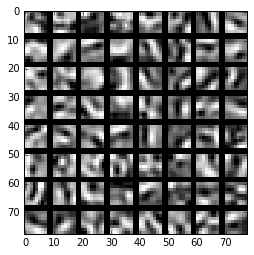

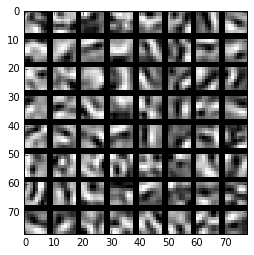

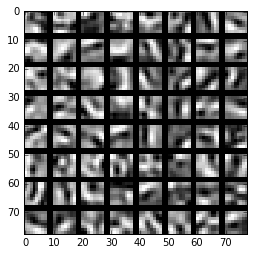

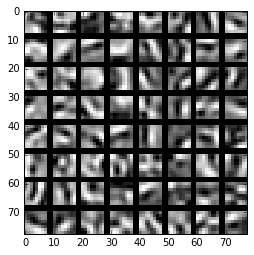

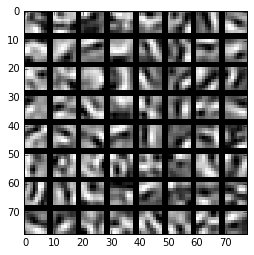

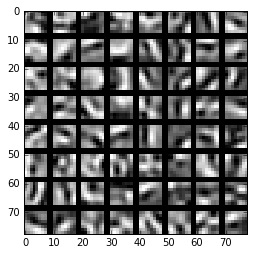

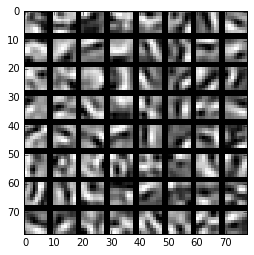

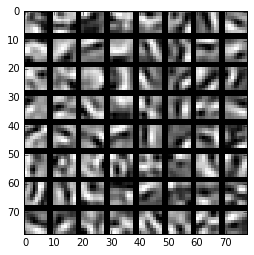

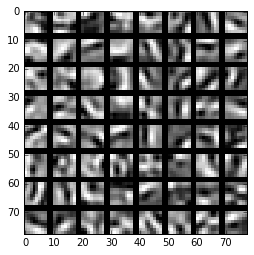

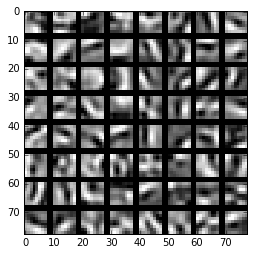

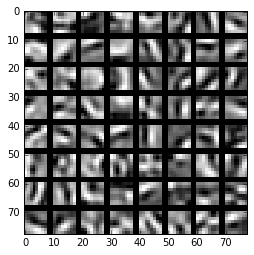

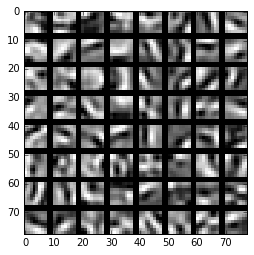

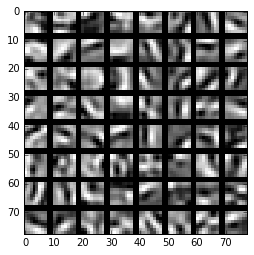

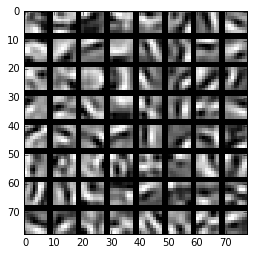

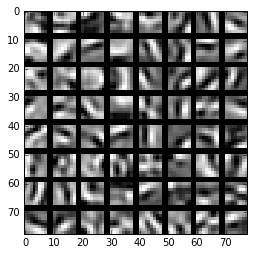

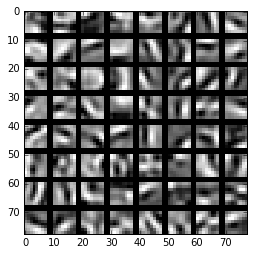

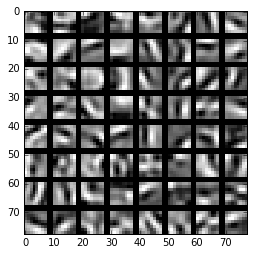

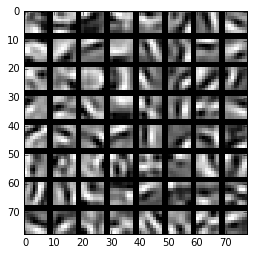

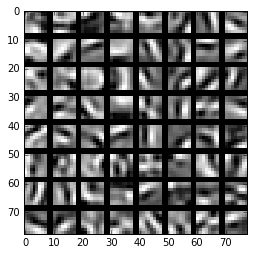

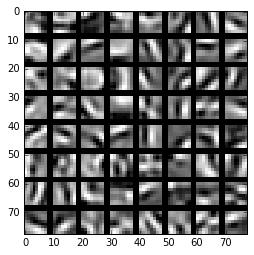

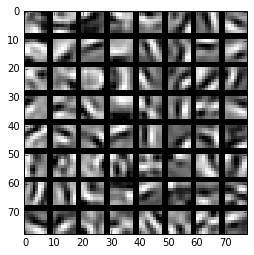

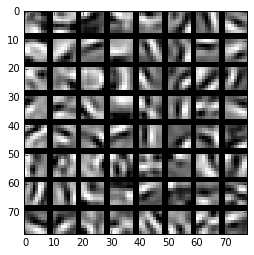

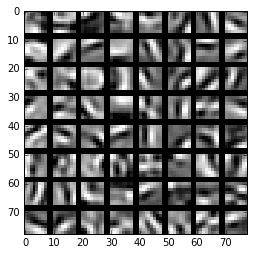

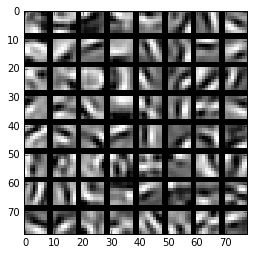

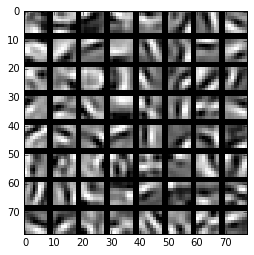

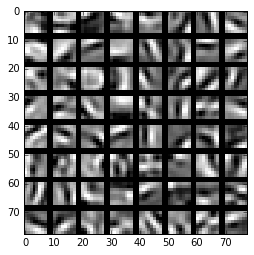

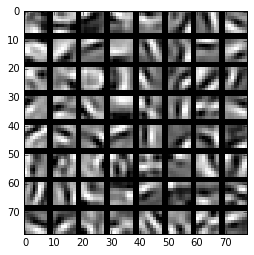

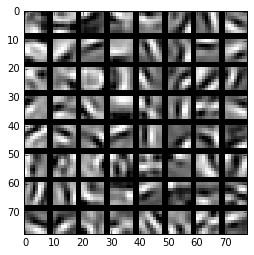

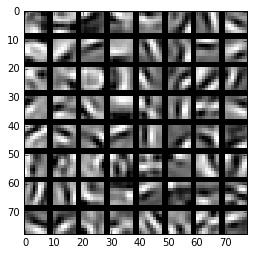

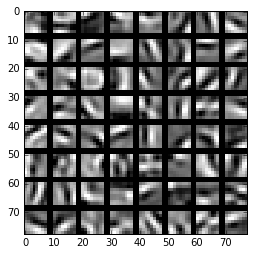

In [255]:
for kk in range(epochs):
    print kk
    for ii in range(int(math.floor(1.*patches.shape[0]/n_batch))):
        zero_a()
        update_x(patches[ii*n_batch : (ii+1)*n_batch])
        for jj in range(n_iter):
            cost, recon, coeff, l0, snr = step_a() 
            if ii == 0:
                cost_array[kk, jj] = cost
                recon_array[kk, jj] = recon
                coeff_array[kk, jj] = coeff
                l0_array[kk, jj] = l0
                snr_array[kk, jj] = snr
        if ii == 0:
            hist_array[kk] = a.get_value()
        #print cost
        step_w()
    plt.figure()
    im = tri(w.get_value()[:64], shape, (8, 8), (2,2))
    #increase 64 
    plt.imshow(im, cmap='gray', interpolation='nearest')

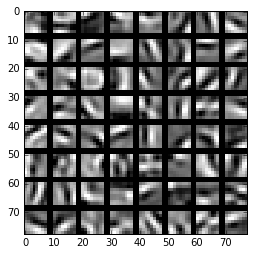

In [256]:
im = tri(w.get_value()[:64], shape, (8, 8), (2,2))
plt.imshow(im, cmap='gray', interpolation='nearest')
plt.savefig(os.path.join(plot_folder, sub, 'reconstructed_image.png'))

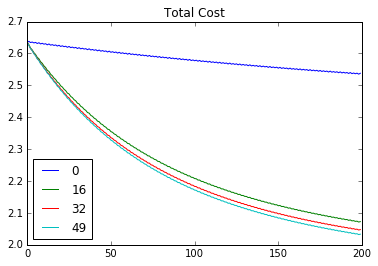

In [257]:
plot_epoch = np.linspace(0,epochs-1,4,dtype = int)
for idx in plot_epoch:
    plt.plot (np.arange(n_iter),cost_array[idx], label = idx)
plt.legend (loc = 'best')
plt.title('Total Cost')
plt.savefig(os.path.join(plot_folder, sub, 'total_cost.png'))

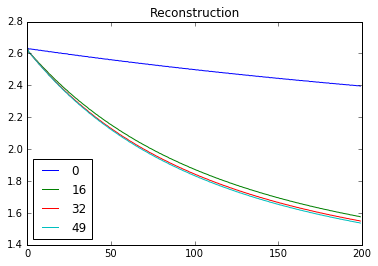

In [258]:
for idx in plot_epoch:
    plt.plot (np.arange(n_iter),recon_array[idx], label = idx)
plt.legend (loc = 'best')
plt.title('Reconstruction')
plt.savefig(os.path.join(plot_folder, sub, 'reconstruction.png'))

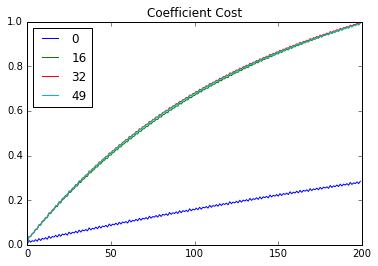

In [259]:
for idx in plot_epoch:
    plt.plot (np.arange(n_iter),coeff_array[idx], label = idx)
plt.legend (loc = 'best')
plt.title('Coefficient Cost')
plt.savefig(os.path.join(plot_folder, sub, 'coefficient_cost.png'))

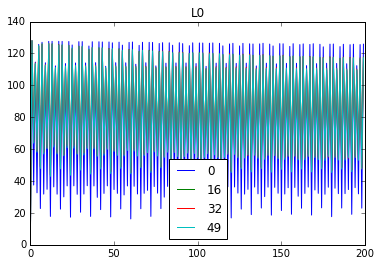

In [260]:
for idx in plot_epoch:
    plt.plot (np.arange(n_iter),l0_array[idx], label = idx)
plt.legend (loc = 'best')
plt.title('L0')
plt.savefig(os.path.join(plot_folder, sub, 'L0.png'))

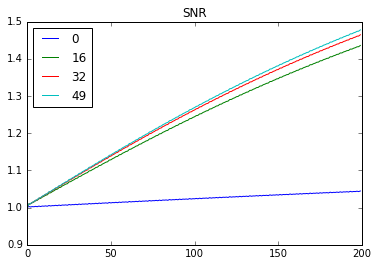

In [261]:
for idx in plot_epoch:
    plt.plot (np.arange(n_iter),snr_array[idx], label = idx)
plt.legend (loc = 'best')
plt.title('SNR')
plt.savefig(os.path.join(plot_folder, sub, 'snr.png'))

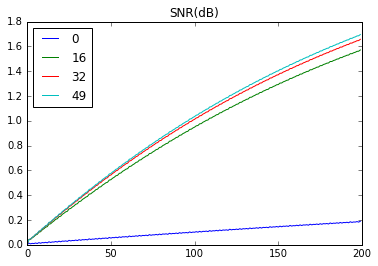

In [262]:
for idx in plot_epoch:
    plt.plot (np.arange(n_iter),10*np.log10(snr_array[idx]), label = idx)
plt.legend (loc = 'best')
plt.title('SNR(dB)')
plt.savefig(os.path.join(plot_folder, sub, 'snr_dB.png'))

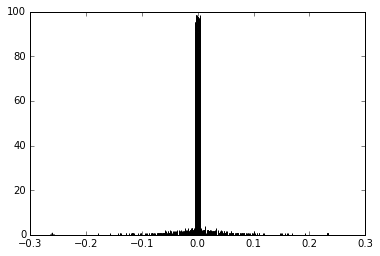

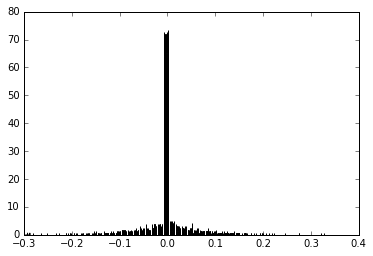

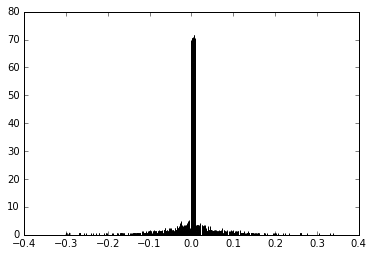

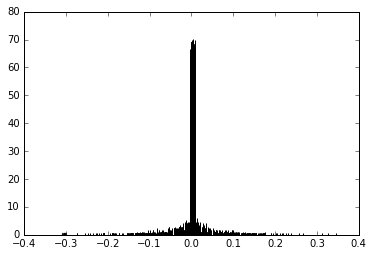

In [263]:
for idx in plot_epoch:
    # the histogram of the data
    plt.figure()
    plt.hist(hist_array[idx], 50, normed=1, facecolor='gray')
plt.savefig(os.path.join(plot_folder, sub, 'histogram.png'))

In [264]:
np.linalg.norm(w.get_value(), axis=1)

array([ 1.00004971,  1.0000186 ,  1.00000107,  1.00000703,  1.00002885,
        1.00000012,  0.99999988,  1.00006223,  1.00005877,  1.00000501,
        1.00000024,  1.00004327,  1.00000024,  1.        ,  1.00005186,
        1.00000012,  1.00001347,  1.00008917,  1.00007725,  1.0000751 ,
        1.00000954,  1.00000024,  1.00000584,  1.00001407,  1.00000215,
        1.00003254,  1.00003529,  1.00011957,  1.00001097,  1.        ,
        1.00000918,  1.00010967,  1.00000191,  1.00003183,  1.00002527,
        1.00001979,  1.00001216,  0.99999988,  1.00000393,  1.00000012,
        1.00000572,  1.        ,  1.00000703,  1.00001037,  1.00001407,
        1.00014675,  1.00000215,  0.99999994,  1.00000012,  1.00000083,
        1.00001371,  1.00005198,  1.00002348,  1.00001228,  1.00000584,
        1.00005341,  1.00004351,  1.        ,  1.00004017,  1.00000668,
        1.00004983,  1.0000155 ,  1.00000024,  1.0000304 ,  1.00006104,
        1.00001788,  1.00001073,  1.00000906,  1.00002933,  1.00